In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [8]:
# Style Settings
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.size'] = 12

In [17]:
# Load Data
# 'parse_dates' so pd recognizes the text as actual time
# 'index_col' so time is our reference index, not row numbers
df = pd.read_csv('data/PJME_hourly.csv', index_col='Datetime', parse_dates=['Datetime'])
df = df.sort_index()

In [18]:
# Inspect Data
print("Top 5 rows:")
print(df.head())

Top 5 rows:
                     PJME_MW
Datetime                    
2002-01-01 01:00:00  30393.0
2002-01-01 02:00:00  29265.0
2002-01-01 03:00:00  28357.0
2002-01-01 04:00:00  27899.0
2002-01-01 05:00:00  28057.0


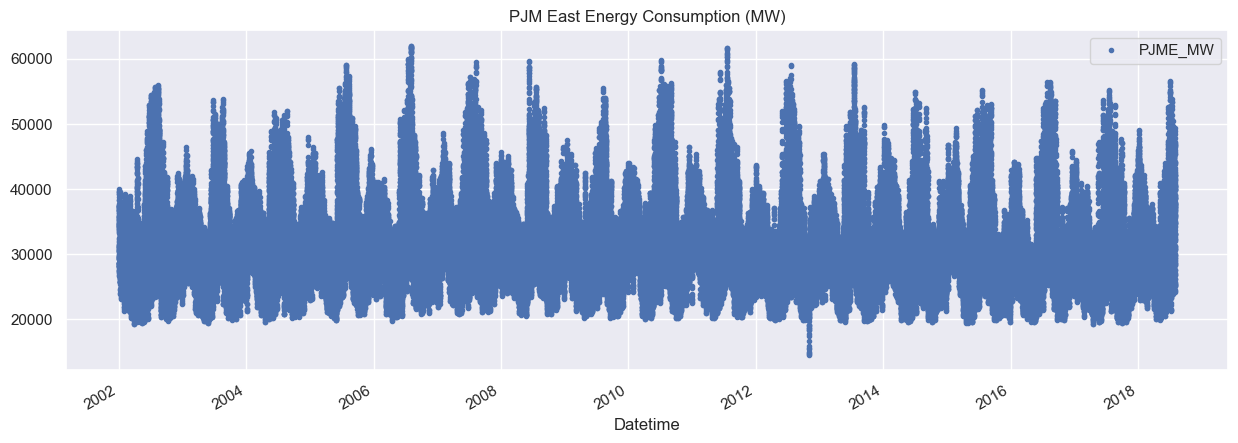

In [19]:
# Visualize Data
# Plot entire history to see overall trends
df.plot(style='.', title='PJM East Energy Consumption (MW)')
plt.show()

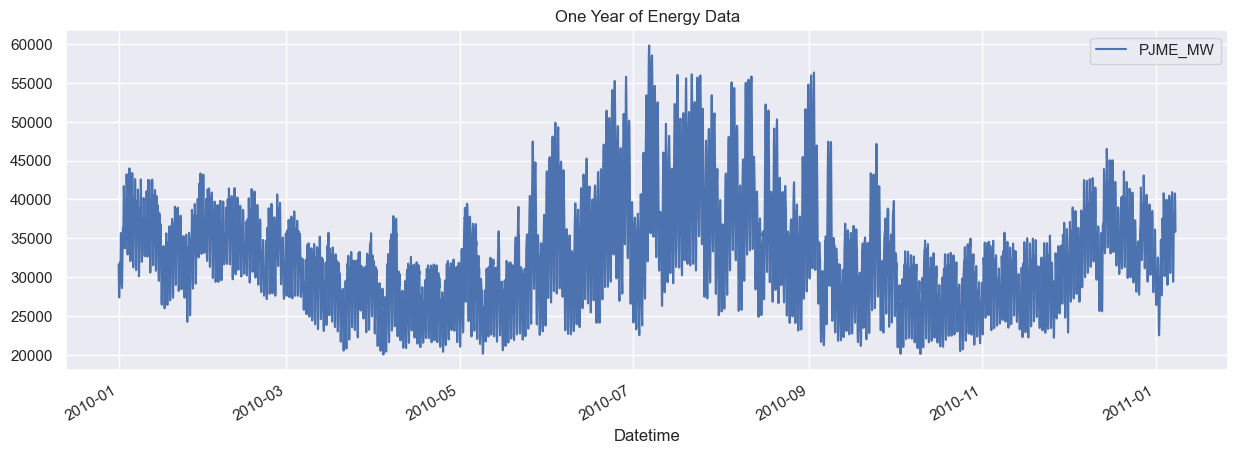

In [21]:
# Zoom In
# Plot a specific year to see seasonal patterns
df.loc["2010-01-01":"2011-01-07"].plot(title="One Year of Energy Data")
plt.show()

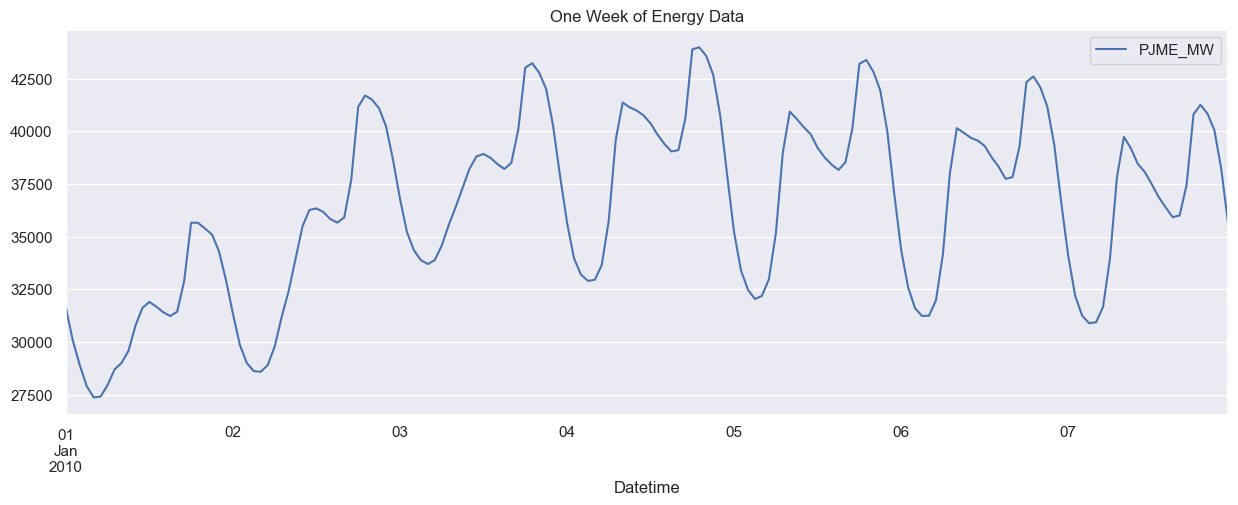

In [ ]:
# Zoom In
# Plot a specific week to see seasonal patterns
df.loc["2010-01-01":"2010-01-07"].plot(title="One Week of Energy Data")
plt.show()

# Pattern Insight

* Year over Year is consistent
* Summer months use the most energy
* Spring and Fall use the least
* Each day has 2 peaks and 1 large dip

# Train Test Split

* Training = Everything before 2015
* Testing = Everything after 2015

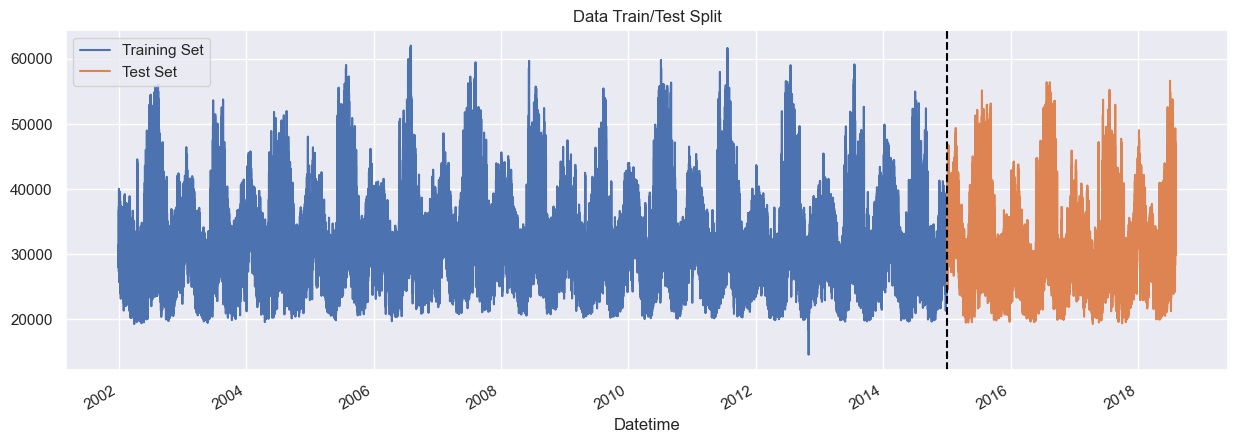

In [22]:
# Train test split
split_date = '2015-01-01'

train = df.loc[df.index < split_date]
test = df.loc[df.index >= split_date]

# Visualize the split
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(split_date, color='black', ls='--')
plt.legend(['Training Set', 'Test Set'])
plt.show()

# Feature Engineering

Embed meaning into the data so that the ML Model can recognize deeper insights
- At 5PM, energy usage is higher
- In August, energy usage is higher
etc.

In [23]:
# Feature Engineering
def create_features(df):
    """
    Creates time series features from the datetime index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

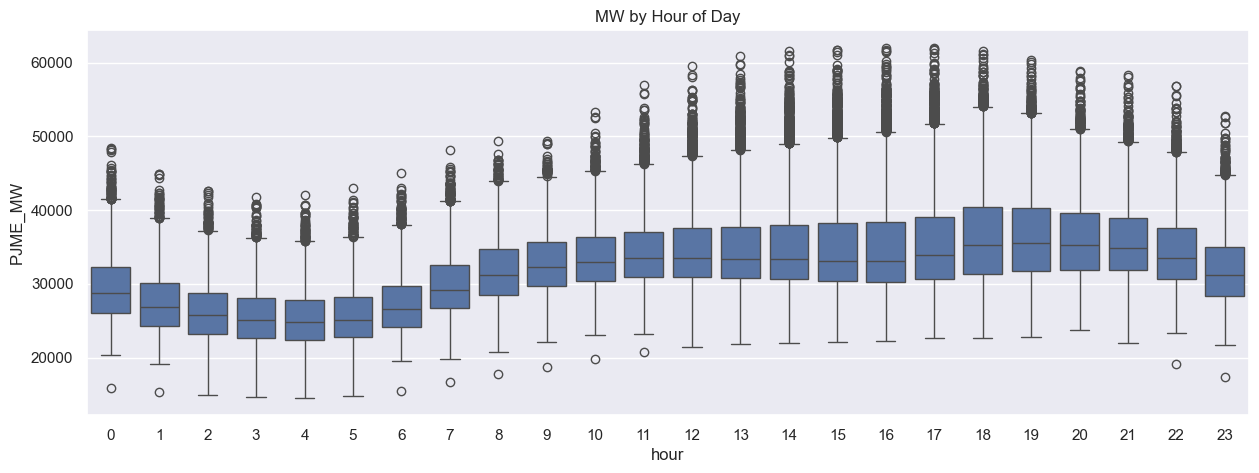

In [24]:
# Apply to data
df = create_features(df)

# Visualize the relationship
# Use boxplot to see distribution of energy consumption by hour of day
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour of Day')
plt.show()

# The Model

Use XGBoost
- tree-based model. Good for categorical features

In [26]:
# Re-split w/ new features
train = df.loc[df.index < '2015-01-01']
test = df.loc[df.index >= '2015-01-01']

# Define input cols and target col
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [27]:
# Model Training
# Regressor for continuous number
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)

# Fit the Model
# Verbose=100, print update every 100 trees (out of 1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729
[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[988]	validation_0-rmse:3060.25324	validation_1-rmse:3728.07396


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

C:\Users\jacob\AppData\Local\Temp\ipykernel_24496\2471543773.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


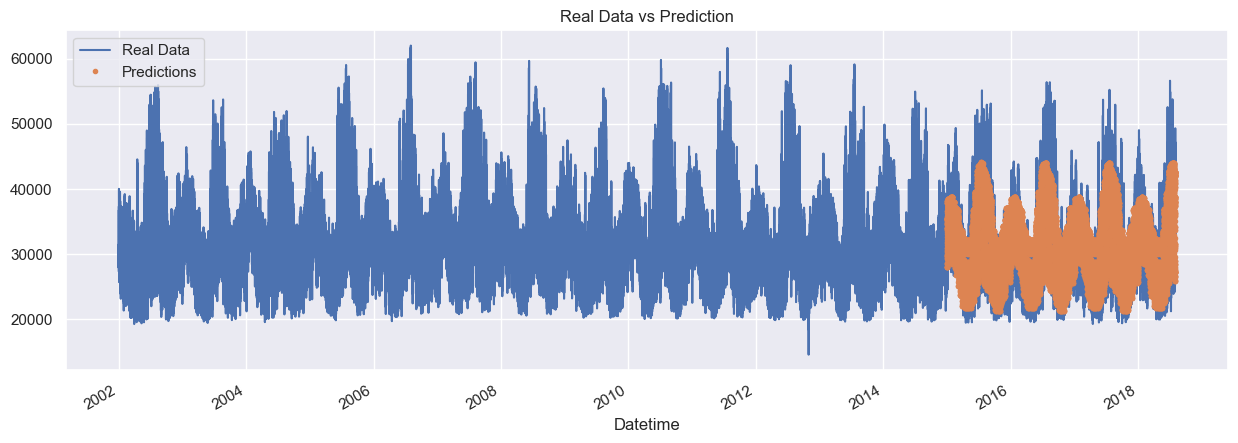

In [28]:
# Prediction
# Add preds back to test df
test['prediction'] = reg.predict(X_test)

# Plot real data vs predicted
df_merge = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df_merge[["PJME_MW"]].plot(figsize=(15,5))
df_merge['prediction'].plot(ax=ax, style='.')
plt.legend(['Real Data', "Predictions"])
ax.set_title("Real Data vs Prediction")
plt.show()

In [29]:
# Calc score (RMSE)
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f"RMSE Score on Test set: {score:0.2f}")

RMSE Score on Test set: 3726.80
